In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install transformers datasets torch scikit-learn


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/jigsaw-unintended-bias-train.csv")

df["toxicity"] = (df["toxic"] >= 0.5).astype(int)

# Use 150k sample
df_sample = df.sample(n=150000, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    df_sample["comment_text"],
    df_sample["toxicity"],
    test_size=0.2,
    stratify=df_sample["toxicity"],
    random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 120000
Test size: 30000


In [4]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
train_encodings = tokenizer(
    X_train.astype(str).tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

test_encodings = tokenizer(
    X_test.astype(str).tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

print("Tokenization done ")

Tokenization done 


In [7]:
import torch

class ToxicDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.values  # numpy array

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ToxicDataset(train_encodings, y_train)
test_dataset = ToxicDataset(test_encodings, y_test)

print("Datasets ready ")


Datasets ready 


In [8]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

print("Model initialized correctly ")


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model initialized correctly 


In [10]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=500,
    load_best_model_at_end=True,
    report_to="none"
)

In [11]:
import numpy as np
from sklearn.metrics import roc_auc_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    return {
        "roc_auc": roc_auc_score(labels, probs)
    }


In [12]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


In [13]:
trainer.train()


Epoch,Training Loss,Validation Loss,Roc Auc
1,0.152705,0.150298,0.940039
2,0.122784,0.162934,0.942056


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=15000, training_loss=0.14576654917399087, metrics={'train_runtime': 3062.9156, 'train_samples_per_second': 78.357, 'train_steps_per_second': 4.897, 'total_flos': 7948043919360000.0, 'train_loss': 0.14576654917399087, 'epoch': 2.0})

In [14]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score

predictions = trainer.predict(test_dataset)

logits = predictions.predictions

# Convert logits to probabilities (2-label setup)
probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()

print("Overall ROC-AUC:", round(roc_auc_score(y_test, probs), 4))


Overall ROC-AUC: 0.94


In [15]:
identity_columns = [
    'male', 'female', 'muslim', 'jewish',
    'black', 'white', 'christian',
    'homosexual_gay_or_lesbian'
]

# Recreate sampled dataframe exactly
df_sample = df.sample(n=150000, random_state=42)
df_sample = df_sample.dropna(subset=["comment_text"])

# Split again to match test indices
_, df_test = train_test_split(
    df_sample,
    test_size=0.2,
    stratify=df_sample["toxicity"],
    random_state=42
)

df_test = df_test.reset_index(drop=True)

df_test["true_label"] = y_test.reset_index(drop=True)
df_test["pred_proba"] = probs


In [16]:
print("\nDistilBERT Subgroup AUC:")

for col in identity_columns:
    subgroup = df_test[df_test[col] > 0.5]

    if len(subgroup) > 100:
        auc = roc_auc_score(subgroup["true_label"], subgroup["pred_proba"])
        print(f"{col}: {round(auc, 4)}")



DistilBERT Subgroup AUC:
male: 0.9492
female: 0.9308
muslim: 0.9337
jewish: 0.9165
black: 0.9275
white: 0.8969
christian: 0.9285
homosexual_gay_or_lesbian: 0.9457


In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import torch

# Get predictions
predictions = trainer.predict(test_dataset)
logits = predictions.predictions

probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
pred_labels = np.argmax(logits, axis=1)

accuracy = accuracy_score(y_test, pred_labels)

print("Final Accuracy:", round(accuracy, 4))
print("\nClassification Report:\n")
print(classification_report(y_test, pred_labels))


Final Accuracy: 0.9479

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     27609
           1       0.77      0.50      0.60      2391

    accuracy                           0.95     30000
   macro avg       0.86      0.74      0.79     30000
weighted avg       0.94      0.95      0.94     30000



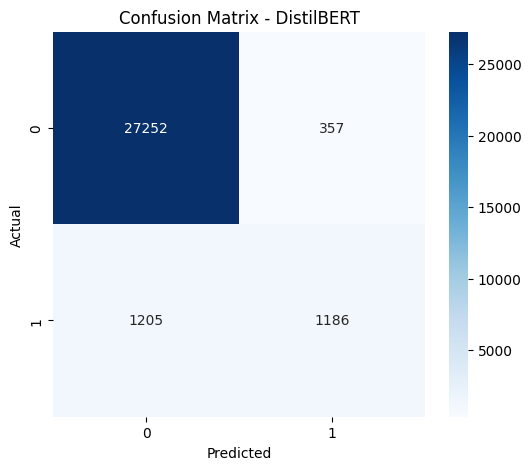

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - DistilBERT")
plt.show()


In [18]:
logs = trainer.state.log_history


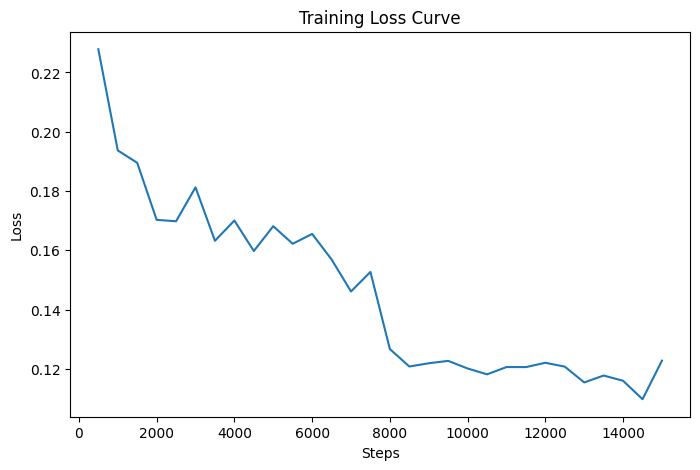

In [20]:
import pandas as pd

logs_df = pd.DataFrame(logs)

# Training loss
train_loss = logs_df[logs_df["loss"].notnull()]

plt.figure(figsize=(8,5))
plt.plot(train_loss["step"], train_loss["loss"])
plt.title("Training Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()


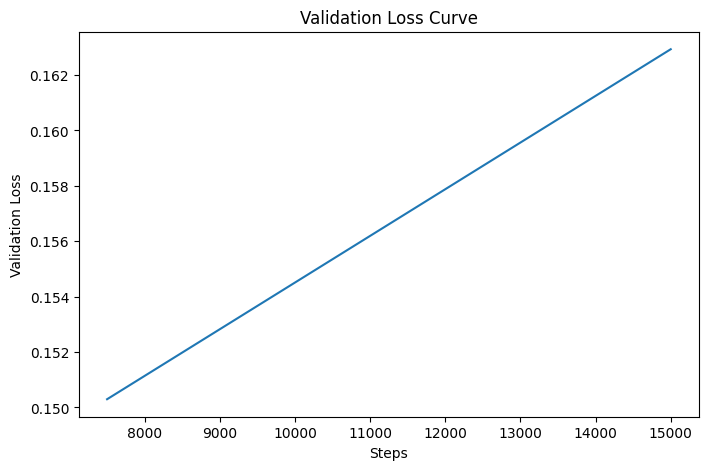

In [21]:
eval_loss = logs_df[logs_df["eval_loss"].notnull()]

plt.figure(figsize=(8,5))
plt.plot(eval_loss["step"], eval_loss["eval_loss"])
plt.title("Validation Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Validation Loss")
plt.show()


In [22]:
trainer.save_model("/content/distilbert_final_model")
tokenizer.save_pretrained("/content/distilbert_final_model")


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('/content/distilbert_final_model/tokenizer_config.json',
 '/content/distilbert_final_model/tokenizer.json')

In [23]:
!zip -r distilbert_final_model.zip /content/distilbert_final_model


  adding: content/distilbert_final_model/ (stored 0%)
  adding: content/distilbert_final_model/config.json (deflated 49%)
  adding: content/distilbert_final_model/model.safetensors (deflated 8%)
  adding: content/distilbert_final_model/tokenizer.json (deflated 71%)
  adding: content/distilbert_final_model/tokenizer_config.json (deflated 42%)
  adding: content/distilbert_final_model/training_args.bin (deflated 53%)


In [24]:
from google.colab import files
files.download("distilbert_final_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>